# 生成式对抗网络（Generative Adversarial Networks）

## GAN 体系结构

![caption](notebook-images/GAN_Overall.png)

## Loading MNIST data

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


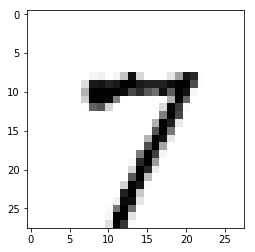

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

## 判别器网络

判别器网络实现了一个卷积神经网络，输入数据为 28 x 28 x 1 的图片，输出一个数值，这个数值表示输入图片是真的图片还是假的图片。

![caption](notebook-images/GAN_Discriminator.png)



In [4]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

## 生成器网络

![caption](notebook-images/GAN_Generator.png)

生成器网络类似一个逆向的卷积神经网络。典型的卷积神经网络将一个 2 维或者 3 维像素张量转换到单一的概率值；生成器网络的输入是一个 d 维的噪声向量，并逐步被上采样转换为一个 28 x 28 的图片。这里使用了 ReLU 函数和批标准化来稳定每层的输出。

我们的生成器网络使用了 3 个带有插值的卷积层来生成  28 x 28 的图片，在输出层，我们使用了 sigmoid 激活函数，这会把像素值挤压到（0,1）区间，对应着非黑即白的锐利图像。

In [5]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

## 生成图片

我们已经定义了生成器和判别器，接下来我们试着用未训练的生成器生成一张图片。

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

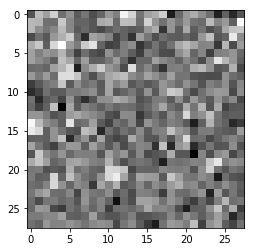

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

## 训练 GAN

GAN 模型的难点之一是它需要设置两个损失函数：一个用于指导生成器生成更好的图片，另一个用于指导判别器判断图片的真伪。生成器和判别器将被同时训练，判别器的判别水平越来越提升，反过来会促进生成器生成质量更好的图片。

In [8]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

我们来设想一下损失函数应该如何设计才能更好的指导我们的网络：判别器的目标是将真正的图片（MNIST数据）判断为真（概率值接近 1），将生成的图片判断为假（概率值接近 0）。因此我们将为判别器设计两个损失函数，一个损失函数计算 Dx 和 1 的距离；另一个计算 Dg 和 0 的距离。

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

生成器的损失函数应该这样设计：我们要让生成器生成能够骗过判别器的图片，即 Dg 的值跟 1 越接近越好。

In [10]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

定义了损失函数后，我们需要进一步定义优化器。生成器网络的优化器应该只更新生成器的权重，不去管辨别器的权重；反之亦然，当我们训练辨别器的时候，我们希望生成器的参数保持稳定。为了实现这种区分，我们创建了两个变量列表，一个保存辨别器的权重和偏置，另一个保存生成器的权重和偏置。我们通过为变量命名实现这种区分。

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

[u'd_w1:0', u'd_b1:0', u'd_w2:0', u'd_b2:0', u'd_w3:0', u'd_b3:0', u'd_w4:0', u'd_b4:0']
[u'g_w1:0', u'g_b1:0', u'g_b1/beta:0', u'g_w2:0', u'g_b2:0', u'g_b2/beta:0', u'g_w3:0', u'g_b3:0', u'g_b3/beta:0', u'g_w4:0', u'g_b4:0']


接下来我们可以分别定义两个优化器：

In [12]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [13]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

模型构造完毕，我们可以开始训练了。我们首先对判别器进行简单的预训练，这可以帮助我们建立好训练基础。然后我们进入训练的主循环。当我们训练生成器时，我们将一个随机变量 z 的向量输入生成器，并将生成的结果传给判别器，计算得到 Dg。生成器的权重和偏置将被更新以产生可以让判别器输出 1 的结果。

训练判别器时，我们将 MNIST 数据集中的图片作为正例输入；将生成器生成的图片作为负例输入。当生成器被训练输出越来越逼真的图片时，判别器也会同步训练提高自己的判别能力。

('dLossReal:', 0.69401968, 'dLossFake:', 0.70872015)
('dLossReal:', 0.013479999, 'dLossFake:', 0.20082188)
('dLossReal:', 0.0028657285, 'dLossFake:', 0.0025388985)
('Iteration:', 0, 'at', datetime.datetime(2018, 5, 29, 9, 5, 9, 5562))


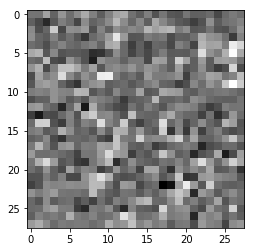

('Estimate:', array([[-7.28953362]], dtype=float32))
('Iteration:', 100, 'at', datetime.datetime(2018, 5, 29, 9, 10, 56, 665004))


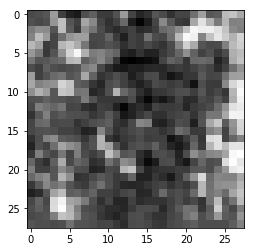

('Estimate:', array([[-7.39222288]], dtype=float32))


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()